# Graph to visualize Twitter performance on LSI.

This notebook is used for subsection 1. What is the optimal number of topics that can be generatedon a set of Twitter messages using a topic model?

In [9]:
#basic python methods
import pandas as pd 
import re
import numpy as np
import umap
from collections import Counter

#gensim models for topic modeling
import gensim
from gensim.test.utils import common_dictionary, common_corpus
from gensim.models import LsiModel, CoherenceModel

#nlp tools
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

#visualizations tools
import matplotlib.pyplot as plt
from matplotlib import pyplot

#word embeddings methods
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from adjustText import adjust_text
import umap

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Load dataset

In [10]:
df = pd.read_csv(r"C:\Users\User\Documents\Thesis\data\twitter_dataset.csv", delimiter = ';')
df = df[0:20000]
df.dropna()

,message,event.cemistry.hashtags
0,#NYC #BROOKLYN please keep your eyes out!!! Pl...,"[ NYC, BROOKLYN, BOOST, QUEER ]"
1,"NEW YORK, Kayla has been missing for almost 48...","[ BOOST, NEWYORK ]"
2,"NEW YORK, Kayla has been missing for almost 48...","[ BOOST, NEWYORK ]"
3,@rohan_connolly #silentmajority #hush,"[ silentmajority, hush ]"
4,Ces travaux d'intérêt général auront lieu le 1...,"[ Burundi, YagaNawe ]"
...,...,...
19995,Need more reasons to attend the 2019 #ChemShow...,"[ ChemShow, CPI ]"
19996,#Burundi — This man is from Kayogoro/Makamba p...,[ Burundi ]
19997,Shots from Sydney Dragway.⁣\n.⁣\n© MPN Digital...,"[ nofilter, DragRacing, hitithard, neverlift, ..."
19998,#Burundi \n#BurundiCrisis,"[ Burundi, BurundiCrisis ]"



Nltk has libaries for common English, French and Spanish words. For other stopwords this set is created.

In [11]:
stopwords_mix = {'oya','ego','canke','amp','&amp','&amp', 'http', 'https', 'plus', 'contre', 'nest', 'cest' ,'après', 'cette', 'burundi', 'comme', 'burundais', 'ong','tout', 'sans',
                     'depuis', 'ils', 'si', 'tous','leurs', 'parti', 'ans', 'selon', 'info','faire',
                     'deux','fait','pace', 'period.','exceeding', 'year-earlier','soaring.'
                    , 'new', 'avoir','très','non','vient','où','quil','jour','encore','get','one', 
                     'like', 'need', 'since','time','last','got','know','well','real','via',"del","por","el","los",
                    "para","di","una","al","https","nhttps",'amp','&amp;','&','!','?',':','-',"alors","au","aucuns","aussi","autre","avant","avec","avoir", "aux","bon","car","ce","cela","ces","ceux","chaque","ci","comme","comment","dans","des",
                    "du","dedans","dehors","depuis","devrait","doit","donc","dos","début","elle","elles","en","encore","essai","est","et","eu","fait","faites","fois",
                    "font","hors","ici","il","ils","je","juste","la","le","les","leur","là","ma","maintenant","mais","mes","mine","moins","mon","mot","même","ni","nommés","notre","nous",
                    "ou","où","par","parce","pas","peut","peu","plupart","pour","pourquoi","quand","que","quel","quelle","quelles","quels","qui","sa","sans","ses",
                    "seulement","si","sien","son","sont","sous","soyes","sujet","sur","ta","tandis","tellement","tels","tes","ton","tous","tout","trop","très","tu","voient",
                    "un","une","vont","votre","vous","vu","ça","étaient","état","étions","été","être","ne","se","y","ont","nos","dit","dire",
                   "c","d","lui","l","moi","va","n","na","rien","autres","bien","sera","suis","vie","soit","quon",
                   "bonne","quils","jamais","entre","k","te","ourselves", "hers", "between", "yourself", "but", "again", "there", "about", "once", 
                     "during", "out", "very", "having", "with", "they", "own", "an", "be", "some", "for", 
                     "do", "de", "its", "yours", "such", "into", "of", "most", "itself", "other", "off", "is", "s", 
                     "am", "or", "who", "as", "from", "him", "each", "the", "themselves", "until", "below", "are", 
                     "we", "these", "your", "his", "through", "don", "nor", "me", "were", "her", "more", "himself", 
                     "this", "down", "should", "our", "their", "while", "above", "both", "up", "to", "ours", "had", 
                     "she", "all", "no", "when", "at", "any", "before", "them", "same", "and", "been", "have", "in", 
                     "will", "on", "does", "yourselves", "then", "that", "because", "what", "over", "why", "so", "can",
                     "did", "not", "now", "under", "he", "you", "herself", "has", "just", "where", "too", "only", "myself",
                     "which", "those", "i", "after", "few", "whom", "t", "being", "if", "theirs", "my", "against", "a", "by",
                     "doing", "it", "how", "further", "was", "here", "than", "https","nhttps",'amp','&amp;','&','!','?',':','-'}

Messages checked on stopwords and characters.

In [12]:
def clean_message(current_message):
    new_string = ""
    p = re.compile('@[a-zA-Z]+')
    findall = p.findall(str(current_message))
    current_message = re.sub(r'@[a-zA-Z]+', '', str(current_message))
    current_message = re.sub(r'[^a-zA-Z ]', '', str(current_message))
    for word in current_message.lower().split(" "):
   
        if not word.startswith("@" or "#" or "http"):
            if not word in set(stopwords.words("english")):
                if not word in set(stopwords.words("french")):
                    if not word in set(stopwords.words("spanish")):
                        if len(word) > 1:
                            if not word in stopwords_mix:
                     
                                new_string += (str(word) + " ")
    return(new_string)

print(clean_message("#NYC #BROOKLYN please keep your eyes out!!!"))
    

nyc brooklyn please keep eyes 


In [13]:
def tokenize_message(current_message):
    new_list = []
    p = re.compile('@[a-zA-Z]+')
    findall = p.findall(str(current_message))
    current_message = re.sub(r'@[a-zA-Z]+', '', str(current_message))
    current_message = re.sub(r'[^a-zA-Z ]', '', str(current_message))
    for word in current_message.lower().split(" "):
   
        if not word.startswith("@" or "#" or "http"):
            if not word in set(stopwords.words("english")):
                if not word in set(stopwords.words("french")):
                    if not word in set(stopwords.words("spanish")):
                        if len(word) > 1:
                            if not word in stopwords_mix:
                     
                                new_list.append(str(word))
    return(new_list)

Tokenized messages are used as input to train a dictionary. 1000 most common words are kept. A word corpus is created form the dictionary.

In [ ]:
df.dropna()

df['clean_message'] = df['message'].apply(clean_message)

df['tokenize_message'] = df['message'].apply(tokenize_message)

dictionary = gensim.corpora.Dictionary(df['tokenize_message'])

dictionary.filter_extremes(no_below=1, no_above=0.5, keep_n=1000)

bow_corpus = [dictionary.doc2bow(doc) for doc in df['tokenize_message']]

# Coherence

$$Coherence  Score  UCI(w_i,w_j)= log(\frac{p(w_i,w_j)}{p(w_i)p(w_j)})$$

In [15]:
def evaluate_graph(dictionary, corpus, texts, limit):
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LsiModel(corpus=bow_corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    print(c_v)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.show()
    
    

For each subset the coherence is calculated for a number of topic (num topics) between 1 and 30

[0.4851379409967581, 0.6781951446220709, 0.5731125612716991, 0.6729886147389271, 0.7025743692798843, 0.6280383177333807, 0.6241517128307604, 0.6559895359326808, 0.6524354751318732, 0.6482362192358221, 0.7533107507148679, 0.5721028539771412, 0.6138786009620038, 0.6653024992762662, 0.6502059700653562, 0.7373308474949114, 0.6459968789062639, 0.6922927197105753, 0.6378486380635691, 0.6432401395192812, 0.5831648544855758, 0.6574555298236491, 0.6169136115285404, 0.6219203061922389, 0.6433069353159472, 0.6781109234660797, 0.5301479713530394, 0.5447958993779763, 0.5802883080256355]


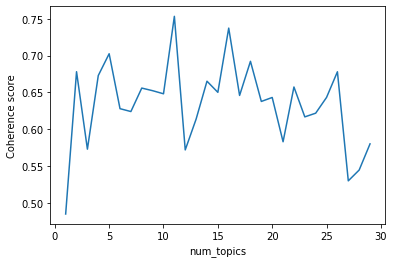

In [16]:
evaluate_graph(dictionary, bow_corpus, df['tokenize_message'], 30)

Output values per subset.

In [19]:
x = range(1,30)
c_v_1 = [0.4851379409967581, 0.6781951446220709, 0.5731125612716991, 0.6729886147389271, 0.7025743692798843, 0.6280383177333807, 0.6241517128307604, 0.6559895359326808, 0.6524354751318732, 0.6482362192358221, 0.7533107507148679, 0.5721028539771412, 0.6138786009620038, 0.6653024992762662, 0.6502059700653562, 0.7373308474949114, 0.6459968789062639, 0.6922927197105753, 0.6378486380635691, 0.6432401395192812, 0.5831648544855758, 0.6574555298236491, 0.6169136115285404, 0.6219203061922389, 0.6433069353159472, 0.6781109234660797, 0.5301479713530394, 0.5447958993779763, 0.5802883080256355]
c_v_2 = [0.5589171210672903, 0.692841740257424, 0.7168145872007332, 0.7655457968423722, 0.7658484214504248, 0.6684565528896466, 0.5785869948215938, 0.7690710419445786, 0.5845444243927445, 0.7132734227434414, 0.6474306337780295, 0.6730882225406396, 0.6043025190105126, 0.5702818458441276, 0.5664745144771955, 0.681974357023842, 0.675472198917503, 0.6374395207945511, 0.6173588690527515, 0.6125712763780056, 0.5752003313459507, 0.5888454618176625, 0.5742646393766813, 0.5842024259794193, 0.5484433031433248, 0.5460841145618521, 0.5277915875962803, 0.589344975307247, 0.5950128697719786]
c_v_3 = [0.2805783177838507, 0.638860255544869, 0.7444222121861973, 0.8083156149610661, 0.9035982350402365, 0.6948390672326, 0.8053542123157132, 0.7221928967639373, 0.608802305142148, 0.6822684911969691, 0.7150605306359856, 0.672034792419903, 0.7141453841704564, 0.6008422985574977, 0.6556184800611801, 0.5934427147499869, 0.6338460424592341, 0.6391368083231727, 0.6310130139695376, 0.5748807839339689, 0.567546352127935, 0.5837060032944742, 0.5974921003009479, 0.5856906592220877, 0.6119348982993402, 0.5885645492087969, 0.5938255144131802, 0.5942460094879946, 0.5964263939706368]
c_v_4 = [0.33417083444651524, 0.38683581416408414, 0.48716093853891224, 0.7411394030801614, 0.5449208756598501, 0.43728150316078324, 0.45490601323598795, 0.33427868352733126, 0.4538259934933445, 0.5269349521181143, 0.5261510885935542, 0.3994182389105043, 0.4008063065428988, 0.45613335310621483, 0.5376052998021991, 0.5461020631450099, 0.5596560789340029, 0.550769658032887, 0.540888791189284, 0.46574486681634975, 0.5744439115926004, 0.5507865813122539, 0.5591420503133078, 0.6100642829234477, 0.5664226551428045, 0.5583662785154354, 0.5447447551172826, 0.5362848436979348, 0.562365023991759]
c_v_5 = [0.5452510118740853, 0.7053297013152632, 0.7737692854245147, 0.6870383511267634, 0.7769188390570254, 0.7924929773550922, 0.6758318109983458, 0.7574452673332117, 0.7543346954138267, 0.6937622469643546, 0.7018213893641416, 0.6880086349351533, 0.5765899206739333, 0.7166617030045084, 0.7041337178377787, 0.7790127071911528, 0.6450841247439228, 0.5998027072647967, 0.6999760909274997, 0.5870049738704426, 0.5823959317058621, 0.6415756598725578, 0.6396552219120225, 0.6250498908531736, 0.5790493937204186, 0.6148019872868465, 0.5661813098192648, 0.6462188723064992, 0.5973739555915527]

Plot to show the coherence of five subsets using LSI algoritm.

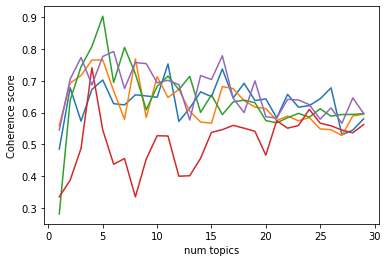

In [21]:
plt.plot(x, c_v_1)
plt.plot(x, c_v_2)
plt.plot(x, c_v_3)
plt.plot(x, c_v_4)
plt.plot(x, c_v_5)
plt.xlabel("num topics")
plt.ylabel("Coherence score")
plt.show()